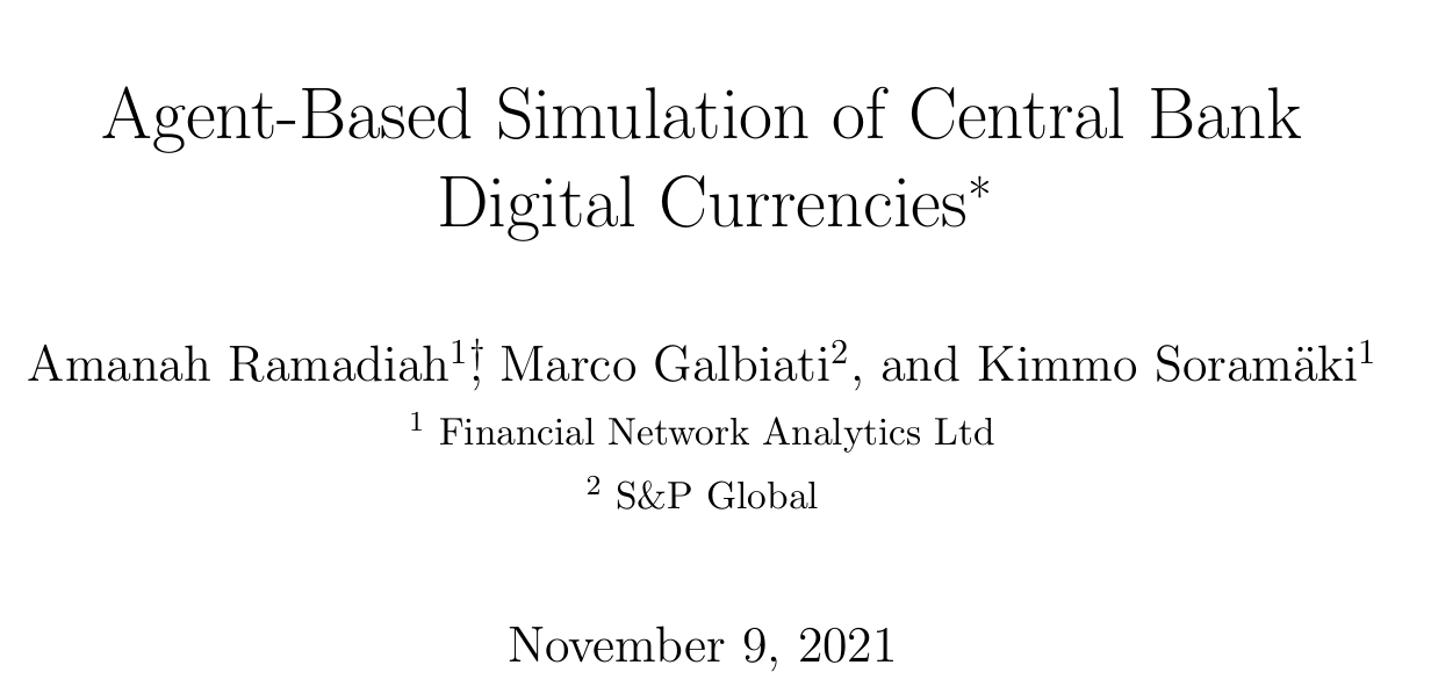

#### Link:  [Agent-Based Simulation of Central Bank Digital Currencies](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3959759)

# Agent_1: Consumer


In [1]:
import mesa
import numpy as np

class ConsumerAgent(mesa.Agent):
    def __init__(self, unique_id, model, initial_cash, initial_deposit, initial_asset, exogenous_salary):
        super().__init__(unique_id, model)
        self.cash = initial_cash
        self.deposit = initial_deposit
        self.asset = initial_asset
        self.cbdc = 0  # Initially no CBDC
        self.wallet = False  # Wallet adoption status
        self.salary = exogenous_salary
        self.average_cbdc_payments = 0
        self.cbdc_payments_count = 0

    def step(self):
        self.receive_income()
        self.update_wealth_allocation()
        self.update_wallet_status()
        self.make_purchase()
        self.top_up_cbdc()
        self.update_wealth_allocation()

    def receive_income(self):
        """ Add salary to deposits at the start of each step."""
        self.deposit += self.salary

    def update_wallet_status(self):
        """ Adjust wallet adoption probability based on the model's diffusion mechanism."""
        if not self.wallet:
            adoption_rate = 0.25 * (self.model.consumers_with_wallets_ratio() + self.model.merchants_accepting_cbdc_ratio())
            self.wallet = self.model.random.random() < adoption_rate

    def make_purchase(self):
        """ Consumers make a mix of online and offline purchases."""
        total_purchases = np.random.poisson(lam=2)  # Number of purchases
        for _ in range(total_purchases):
            purchase_value = np.exp(np.random.normal(np.log(14.21), 5.0))
            is_online = np.random.rand() < 0.2  # 20% probability for online purchase

            if is_online:
                self.make_online_purchase(purchase_value)
            else:
                self.make_offline_purchase(purchase_value)

    def make_online_purchase(self, purchase_value):
        """ Online purchases can be made via deposit or CBDC."""
        if self.deposit >= purchase_value:
            self.deposit -= purchase_value
        elif self.wallet and self.cbdc >= purchase_value:
            self.cbdc -= purchase_value
            self.update_cbdc_payment_stats(purchase_value)
        elif self.wallet and self.cbdc < purchase_value and self.deposit >= purchase_value:
            # Top-up CBDC if needed
            top_up_amount = min(purchase_value, self.deposit, 1000 - self.cbdc)
            self.cbdc += top_up_amount
            self.deposit -= top_up_amount
            if self.cbdc >= purchase_value:
                self.cbdc -= purchase_value
                self.update_cbdc_payment_stats(purchase_value)

    def make_offline_purchase(self, purchase_value):
        """ Offline purchases can be made via cash, deposit, or CBDC."""
        payment_options = []
        if self.cash >= purchase_value:
            payment_options.append('cash')  # Cash is only for offline transactions
        if self.wallet and self.cbdc >= purchase_value:
            payment_options.append('cbdc')
        if self.deposit >= purchase_value:
            payment_options.append('deposit')

        if payment_options:
            chosen_option = self.model.random.choice(payment_options)
            if chosen_option == 'cash':
                self.cash -= purchase_value
            elif chosen_option == 'cbdc':
                self.cbdc -= purchase_value
                self.update_cbdc_payment_stats(purchase_value)
            elif chosen_option == 'deposit':
                self.deposit -= purchase_value

    def update_cbdc_payment_stats(self, purchase_value):
        """ Update the average CBDC payments for future top-ups."""
        self.cbdc_payments_count += 1
        self.average_cbdc_payments = ((self.average_cbdc_payments * (self.cbdc_payments_count - 1)) + purchase_value) / self.cbdc_payments_count

    def top_up_cbdc(self):
        """ Consumers top up their CBDC wallet based on past payment behavior."""
        if self.wallet and self.cbdc < 1000:
            if self.cbdc_payments_count > 0:
                top_up_amount = min(10 * self.average_cbdc_payments, self.deposit, 1000 - self.cbdc)
            else:
                top_up_amount = min(100, self.deposit, 1000 - self.cbdc)
            self.cbdc += top_up_amount
            self.deposit -= top_up_amount

    def update_wealth_allocation(self):
        """ Adjust the allocation between deposits and assets based on returns."""
        total_wealth = self.total_wealth()
        target_asset_ratio = 1 - (self.model.return_on_asset() / self.model.deposit_interest_rate())
        target_asset_allocation = target_asset_ratio * total_wealth
        
        if target_asset_allocation > self.asset:
            allocation_amount = target_asset_allocation - self.asset
            allocation_amount = min(allocation_amount, self.deposit)
            self.asset += allocation_amount
            self.deposit -= allocation_amount
        
        # Ensure minimum cash and CBDC balances
        self.cash = max(self.cash, 20)
        self.cbdc = max(self.cbdc, 10)

    def total_wealth(self):
        """ Compute total wealth across all asset classes."""
        return self.cash + self.deposit + self.asset + self.cbdc


# # Agent_2:Merchant 

In [2]:
import numpy as np
from mesa import Agent

class MerchantAgent(Agent):
    def __init__(self, unique_id, model, accepts_card, accepts_cbdc, initial_cbdc_adoption, acceptance_function):
        super().__init__(unique_id, model)
        self.accepts_card = accepts_card
        self.accepts_cbdc = accepts_cbdc
        self.initial_cbdc_adoption = initial_cbdc_adoption
        self.acceptance_function = acceptance_function
        self.total_purchases = 0
        self.cbdc_purchases = 0
        self.card_purchases = 0
        self.cash_purchases = 0

    def step(self):
        """ Update acceptance of CBDC based on customer interactions."""
        self.update_acceptance()

    def update_acceptance(self):
        """ Adjusts CBDC acceptance based on consumer interactions."""
        total_customers = 0
        cbdc_users = 0
        
        for agent in self.model.schedule.agents:
            if isinstance(agent, ConsumerAgent):
                total_customers += 1
                if agent.wallet and agent.cbdc > 0:
                    cbdc_users += 1
        
        if total_customers > 0:
            adoption_rate = cbdc_users / total_customers
            if not self.accepts_cbdc and np.random.random() < self.acceptance_function(adoption_rate):
                self.accepts_cbdc = True

    def make_purchase(self, amount, payment_method):
        """ Handles purchases and updates records based on payment type."""
        self.total_purchases += amount
        
        if payment_method == "CBDC" and self.accepts_cbdc:
            self.cbdc_purchases += amount
            self.model.total_cbdc_transactions += amount
        elif payment_method == "Card" and self.accepts_card:
            self.card_purchases += amount
            self.model.total_card_transactions += amount
        elif payment_method == "Cash":
            self.cash_purchases += amount
            self.model.total_cash_transactions += amount
        else:
            # Purchase fails if merchant does not accept the selected method
            pass

# Define the acceptance function h(z)
def acceptance_function(z):
    return 0.25 * z


# Agent_3: Commercial banks 

In [3]:
import mesa
import numpy as np

class CommercialBankAgent(mesa.Agent):
    def __init__(self, unique_id, model, initial_deposit, initial_cbdc, initial_asset, deposit_interest_rate, return_on_risky_assets, liquidation_friction, borrowing_markup, balance_adjustment, leverage_target, adjustment_speed):
        super().__init__(unique_id, model)
        self.deposit = initial_deposit
        self.cbdc = initial_cbdc
        self.asset = initial_asset
        self.loan = 0
        self.deposit_interest_rate = deposit_interest_rate
        self.return_on_risky_assets = return_on_risky_assets
        self.liquidation_friction = liquidation_friction
        self.borrowing_markup = borrowing_markup
        self.balance_adjustment = balance_adjustment
        self.leverage_target = leverage_target
        self.borrowed_cbdc = 0
        self.risky_projects_return = 0
        self.adjustment_speed = adjustment_speed

    def step(self):
        self.receive_deposits()
        self.manage_liquidity()
        self.adjust_balance_sheet()
        self.update_interest_rates()
        self.calculate_profit()

    def receive_deposits(self):
        net_deposit_change = self.model.get_total_deposit_change()
        self.deposit += net_deposit_change

    def deposit_change(self):
        """Calculate the net change in deposits from all consumers."""
        return sum(agent.salary for agent in self.model.schedule.agents if isinstance(agent, ConsumerAgent))

    def manage_liquidity(self):
        liquidity_need = (self.deposit * self.deposit_interest_rate + self.borrowed_cbdc * self.borrowing_markup)
        if liquidity_need > self.cbdc:
            self.borrow_cbdc(liquidity_need - self.cbdc)
        else:
            self.pay_back_cbdc(self.cbdc - liquidity_need)

    def borrow_cbdc(self, amount):
        max_borrowable = self.model.central_bank.max_cbdc_balance - self.borrowed_cbdc
        borrow_amount = min(amount, max_borrowable)
        self.loan += borrow_amount
        self.cbdc += borrow_amount
        self.borrowed_cbdc += borrow_amount

    def pay_back_cbdc(self, amount):
        repay_amount = min(amount, self.borrowed_cbdc, self.cbdc)
        self.loan -= repay_amount
        self.cbdc -= repay_amount
        self.borrowed_cbdc -= repay_amount

    def adjust_balance_sheet(self):
        current_leverage = self.compute_leverage()
        target_leverage = self.compute_leverage_target()
        if current_leverage > target_leverage:
            self.liquidate_assets()
        else:
            self.fund_risky_projects()

    def compute_leverage(self):
        total_debt = self.deposit + self.borrowed_cbdc
        equity = max(self.asset - total_debt, 1)
        return total_debt / equity

    def compute_leverage_target(self):
        spread = self.return_on_risky_assets - self.borrowing_markup
        return self.leverage_target * (1 - 1 / spread) if spread > 0 else 0

    def liquidate_assets(self):
        required_liquidity = self.compute_required_liquidity()
        liquidation_amount = required_liquidity / self.liquidation_friction
        self.asset = max(self.asset - liquidation_amount, 0)
        self.cbdc += required_liquidity

    def compute_required_liquidity(self):
        return max((self.deposit + self.borrowed_cbdc) * (self.leverage_target - self.compute_leverage()), 0)

    def fund_risky_projects(self):
        available_funds = self.cbdc - self.compute_required_liquidity()
        if available_funds > 0:
            investment_amount = min(available_funds, np.random.uniform(50000, 150000))  # Reduce investment size
            self.asset += investment_amount
            self.cbdc -= investment_amount
            self.risky_projects_return = np.random.normal(0.02, 0.005) * investment_amount
            self.asset += self.risky_projects_return

    def update_interest_rates(self):
        self.deposit_interest_rate = self.model.central_bank.cbdc_borrowing_rate + self.borrowing_markup

    def calculate_profit(self):
        profit = self.risky_projects_return - (self.deposit * self.deposit_interest_rate) - (self.borrowed_cbdc * self.borrowing_markup)
        self.model.total_profit += profit
        liquidity_need = (self.deposit * self.deposit_interest_rate + self.borrowed_cbdc * self.borrowing_markup)
        if liquidity_need > self.cbdc:
            self.liquidate_assets_for_liquidity(liquidity_need - self.cbdc)
        else:
            self.invest_surplus_liquidity(self.cbdc - liquidity_need)

    def liquidate_assets_for_liquidity(self, amount_needed):
        liquidation_amount = amount_needed / self.liquidation_friction
        self.asset = max(self.asset - liquidation_amount, 0)
        self.cbdc += amount_needed

    def invest_surplus_liquidity(self, surplus_amount):
        self.asset += surplus_amount
        self.cbdc -= surplus_amount


# Agent_4: Central Banks 

In [4]:
import mesa
import numpy as np

class CentralBankAgent(mesa.Agent):
    def __init__(self, unique_id, model, max_cbdc_balance, cash_withdrawal_limit, max_leverage_ratio, initial_cbdc_borrowing_rate):
        super().__init__(unique_id, model)
        self.max_cbdc_balance = max_cbdc_balance
        self.cash_withdrawal_limit = cash_withdrawal_limit
        self.max_leverage_ratio = max_leverage_ratio
        self.cbdc_borrowing_rate = initial_cbdc_borrowing_rate
        self.inflation_rate = 0.02
        self.policy_type = "constant"
        self.previous_avg_assets = None  # Track past asset values

    def step(self):
        self.set_monetary_policy()
        self.manage_cbdc_issuance()

    def set_monetary_policy(self):
        if self.policy_type == "constant":
            pass  # Keep rate unchanged
        elif self.policy_type == "growth-targeting":
            self.cbdc_borrowing_rate = self.compute_growth_targeting_rate()
        elif self.policy_type == "macroprudential":
            self.cbdc_borrowing_rate = self.compute_macroprudential_rate()

    def compute_growth_targeting_rate(self):
        commercial_banks = [agent for agent in self.model.schedule.agents if isinstance(agent, CommercialBankAgent)]
        if not commercial_banks:
            return self.cbdc_borrowing_rate

        avg_assets = np.mean([bank.asset for bank in commercial_banks])
        if self.previous_avg_assets is None:
            self.previous_avg_assets = avg_assets

        delta_X = avg_assets - self.previous_avg_assets
        self.previous_avg_assets = avg_assets
        return max(self.cbdc_borrowing_rate + 0.001 * delta_X, 0)

    def compute_macroprudential_rate(self):
        commercial_banks = [agent for agent in self.model.schedule.agents if isinstance(agent, CommercialBankAgent)]
        if not commercial_banks:
            return self.cbdc_borrowing_rate

        avg_growth = np.mean([(bank.asset - bank.initial_asset) for bank in commercial_banks])
        if avg_growth > 0:
            self.max_leverage_ratio *= 0.99  # Tighten leverage constraint
        else:
            self.max_leverage_ratio *= 1.01  # Loosen leverage constraint
        
        return self.cbdc_borrowing_rate
    
    def manage_cbdc_issuance(self):
        for agent in self.model.schedule.agents:
            if isinstance(agent, CommercialBankAgent):
                liquidity_need = (agent.deposit * agent.deposit_interest_rate + agent.borrowed_cbdc * self.cbdc_borrowing_rate) - agent.model.get_total_deposit_change()
                issuance_amount = min(self.cash_withdrawal_limit, self.max_cbdc_balance - agent.cbdc)
                if issuance_amount > 0 and self.check_leverage_constraint(agent, issuance_amount):
                    agent.cbdc += issuance_amount
                    agent.borrowed_cbdc += issuance_amount

    def check_leverage_constraint(self, agent, issuance_amount):
        new_debt = agent.borrowed_cbdc + issuance_amount
        total_debt = agent.deposit + new_debt
        equity = max(agent.asset - total_debt, 1)  # Prevent division by zero
        new_leverage = total_debt / equity
        return new_leverage <= self.max_leverage_ratio

# Model 

Combining all the Agents

In [5]:
import mesa
import numpy as np
import matplotlib.pyplot as plt
from mesa.datacollection import DataCollector

class CBDCModel(mesa.Model):
    def __init__(self, num_consumers, num_merchants, initial_bank_deposit, initial_cbdc_balance, initial_bank_asset, bank_interest_rate, bank_risky_assets_return, bank_liquidation_friction, bank_borrowing_markup, bank_balance_adjustment, bank_leverage_target, bank_adjustment_speed, max_cbdc_balance, cash_withdrawal_limit, max_leverage_ratio, initial_cbdc_borrowing_rate, exogenous_salary):
        super().__init__()
        self.num_consumers = num_consumers
        self.num_merchants = num_merchants
        self.schedule = mesa.time.RandomActivation(self)
        self.central_bank_rate = initial_cbdc_borrowing_rate
        self.previous_avg_assets = initial_bank_asset
        self.total_profit = 0
        self.total_cbdc_transactions = 0
        self.total_card_transactions = 0
        self.total_cash_transactions = 0
        
        # Initialize purchase tracking variables
        self.total_cash_value = 0
        self.total_cash_volume = 0
        self.total_cbdc_value = 0
        self.total_cbdc_volume = 0
        self.total_deposit_value = 0
        self.total_deposit_volume = 0
        
        self.previous_deposit = initial_bank_deposit
        
        self.datacollector = DataCollector(
            model_reporters={
                "Consumer CBDC Adoption": lambda m: m.consumers_with_wallets_ratio(),
                "Merchant CBDC Acceptance": lambda m: m.merchants_accepting_cbdc_ratio(),
                "CBDC Purchase Value": lambda m: m.total_cbdc_value,
                "Cash Purchase Value": lambda m: m.total_cash_value,
                "Deposit Purchase Value": lambda m: m.total_deposit_value,
                "CBDC Purchase Volume": lambda m: m.total_cbdc_volume,
                "Cash Purchase Volume": lambda m: m.total_cash_volume,
                "Deposit Purchase Volume": lambda m: m.total_deposit_volume,
                "CBDC to Deposit Ratio": lambda m: m.commercial_bank.cbdc / m.commercial_bank.deposit,
                "Bank Deposit Growth Rate": lambda m: (m.commercial_bank.deposit - m.previous_deposit) / m.previous_deposit,
                "Total Asset": lambda m: m.commercial_bank.asset,
                "Total Deposit": lambda m: m.commercial_bank.deposit
            },
            agent_reporters={
                "Deposit": lambda a: a.deposit if isinstance(a, ConsumerAgent) else None,
                "CBDC": lambda a: a.cbdc if isinstance(a, ConsumerAgent) else None,
                "Cash": lambda a: a.cash if isinstance(a, ConsumerAgent) else None,
                "Asset": lambda a: a.asset if isinstance(a, ConsumerAgent) else None
            }
        )
        
        # Create agents
        for i in range(num_consumers):
            initial_deposit = np.random.lognormal(mean=np.log(7100), sigma=1)
            consumer = ConsumerAgent(
                i, self, initial_cash=200, initial_deposit=initial_deposit,
                initial_asset=initial_bank_asset / num_consumers, exogenous_salary=exogenous_salary)
            self.schedule.add(consumer)
        
        for i in range(num_merchants):
            merchant = MerchantAgent(
                i + num_consumers, self, accepts_card=np.random.random() < 0.2, accepts_cbdc=np.random.random() < 0.3,
                initial_cbdc_adoption=0.1, acceptance_function=acceptance_function)
            self.schedule.add(merchant)
        
        self.commercial_bank = CommercialBankAgent(
            num_consumers + num_merchants, self, initial_deposit=initial_bank_deposit, initial_cbdc=initial_cbdc_balance,
            initial_asset=initial_bank_asset, deposit_interest_rate=bank_interest_rate, return_on_risky_assets=bank_risky_assets_return,
            liquidation_friction=bank_liquidation_friction, borrowing_markup=bank_borrowing_markup, balance_adjustment=bank_balance_adjustment,
            leverage_target=bank_leverage_target, adjustment_speed=bank_adjustment_speed)
        self.schedule.add(self.commercial_bank)
        
        self.central_bank = CentralBankAgent(
            num_consumers + num_merchants + 1, self, max_cbdc_balance=max_cbdc_balance, cash_withdrawal_limit=cash_withdrawal_limit,
            max_leverage_ratio=max_leverage_ratio, initial_cbdc_borrowing_rate=initial_cbdc_borrowing_rate)
        self.schedule.add(self.central_bank)
    
    def step(self):
        # Reset transaction trackers before each step
        self.total_cbdc_value, self.total_cash_value, self.total_deposit_value = 0, 0, 0
        self.total_cbdc_volume, self.total_cash_volume, self.total_deposit_volume = 0, 0, 0
        
        for agent in self.schedule.agents:
            if isinstance(agent, ConsumerAgent):
                agent.make_purchase()
        
        self.schedule.step()
        
        # Track deposit and asset growth
        self.total_deposit = sum(agent.deposit for agent in self.schedule.agents if isinstance(agent, ConsumerAgent))
        self.total_asset = sum(agent.asset for agent in self.schedule.agents if isinstance(agent, ConsumerAgent))
        
        self.datacollector.collect(self)
        self.central_bank.set_monetary_policy()
    
    def return_on_asset(self):
        return 0.03
    
    def deposit_interest_rate(self):
        return self.commercial_bank.deposit_interest_rate
    
    def consumers_with_wallets_ratio(self):
        return sum(1 for agent in self.schedule.agents if isinstance(agent, ConsumerAgent) and agent.wallet) / self.num_consumers

    def merchants_accepting_cbdc_ratio(self):
        return sum(1 for agent in self.schedule.agents if isinstance(agent, MerchantAgent) and agent.accepts_cbdc) / self.num_merchants
    
    def get_total_deposit_change(self):
        return sum(agent.salary for agent in self.schedule.agents if isinstance(agent, ConsumerAgent))


# Run the model
model = CBDCModel(
    num_consumers=1500, num_merchants=15, initial_bank_deposit=3000000, initial_cbdc_balance=1000000, initial_bank_asset=4200000,
    bank_interest_rate=0.005, bank_risky_assets_return=0.012, bank_liquidation_friction=0.95, bank_borrowing_markup=0.003, bank_balance_adjustment=1,
    bank_leverage_target=32.3, bank_adjustment_speed=1, max_cbdc_balance=1000, cash_withdrawal_limit=300, max_leverage_ratio=32.3,
    initial_cbdc_borrowing_rate=0.002, exogenous_salary=18)
for i in range(100):
    model.step()

# Retrieve and visualize data
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

model_data.to_csv("model_results.csv")
agent_data.to_csv("agent_results.csv")


### Load Data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load model and agent data
model_data = pd.read_csv("model_results.csv")
agent_data = pd.read_csv("agent_results.csv")


### Adoption Rate of CBDC Over Time

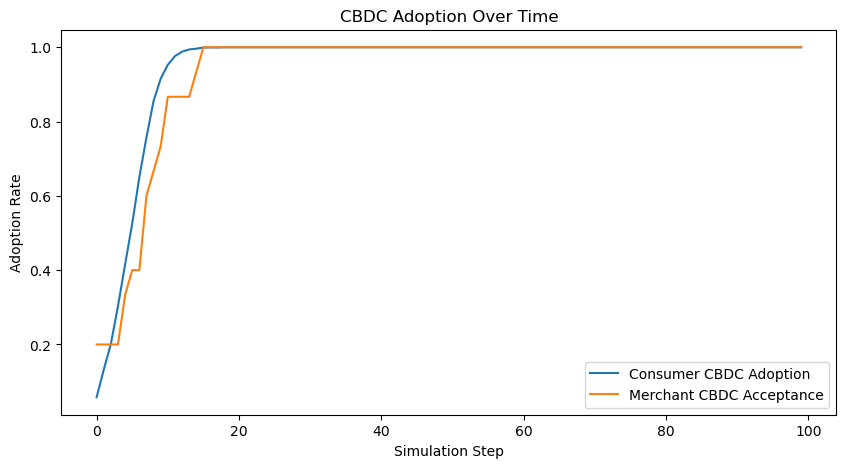

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(model_data["Consumer CBDC Adoption"], label="Consumer CBDC Adoption")
plt.plot(model_data["Merchant CBDC Acceptance"], label="Merchant CBDC Acceptance")
plt.xlabel("Simulation Step")
plt.ylabel("Adoption Rate")
plt.title("CBDC Adoption Over Time")
plt.legend()
plt.show()

### Volume and Value of Purchases by CBDC, Cash, and Deposit

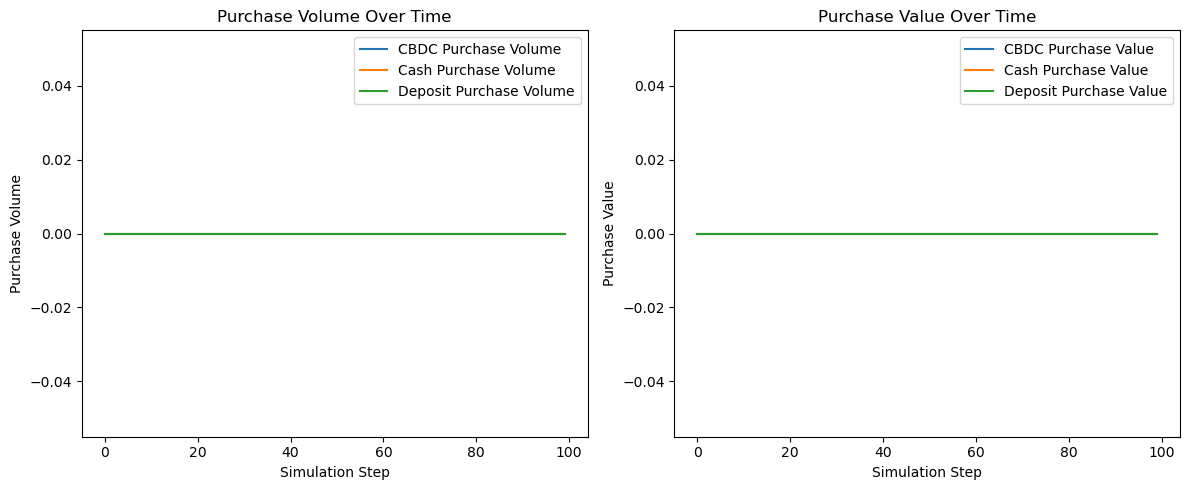

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Purchase Volume
axes[0].plot(model_data["CBDC Purchase Volume"], label="CBDC Purchase Volume")
axes[0].plot(model_data["Cash Purchase Volume"], label="Cash Purchase Volume")
axes[0].plot(model_data["Deposit Purchase Volume"], label="Deposit Purchase Volume")
axes[0].set_xlabel("Simulation Step")
axes[0].set_ylabel("Purchase Volume")
axes[0].set_title("Purchase Volume Over Time")
axes[0].legend()

# Purchase Value
axes[1].plot(model_data["CBDC Purchase Value"], label="CBDC Purchase Value")
axes[1].plot(model_data["Cash Purchase Value"], label="Cash Purchase Value")
axes[1].plot(model_data["Deposit Purchase Value"], label="Deposit Purchase Value")
axes[1].set_xlabel("Simulation Step")
axes[1].set_ylabel("Purchase Value")
axes[1].set_title("Purchase Value Over Time")
axes[1].legend()

plt.tight_layout()
plt.show()


### Wealth Distribution of Consumers (CBDC, Cash, Deposit, Asset) Over Time

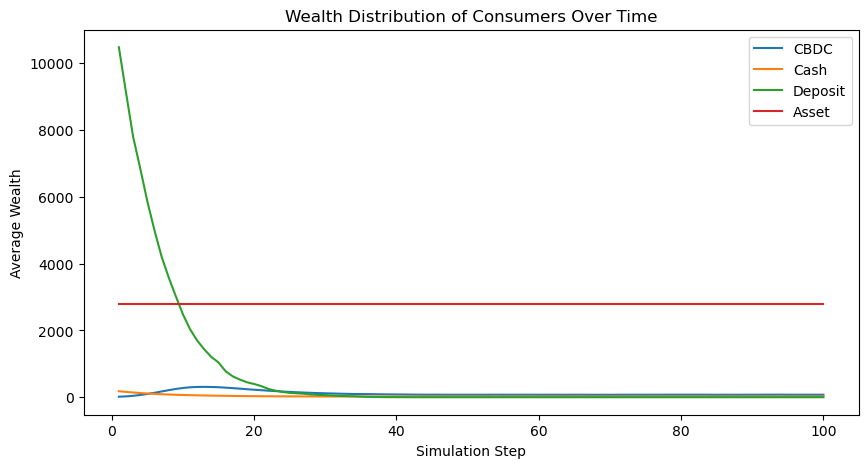

In [9]:
average_wealth = agent_data.groupby("Step")[["CBDC", "Cash", "Deposit", "Asset"]].mean()

plt.figure(figsize=(10, 5))
plt.plot(average_wealth["CBDC"], label="CBDC")
plt.plot(average_wealth["Cash"], label="Cash")
plt.plot(average_wealth["Deposit"], label="Deposit")
plt.plot(average_wealth["Asset"], label="Asset")
plt.xlabel("Simulation Step")
plt.ylabel("Average Wealth")
plt.title("Wealth Distribution of Consumers Over Time")
plt.legend()
plt.show()


### Total Asset and Deposit Changes Over Time

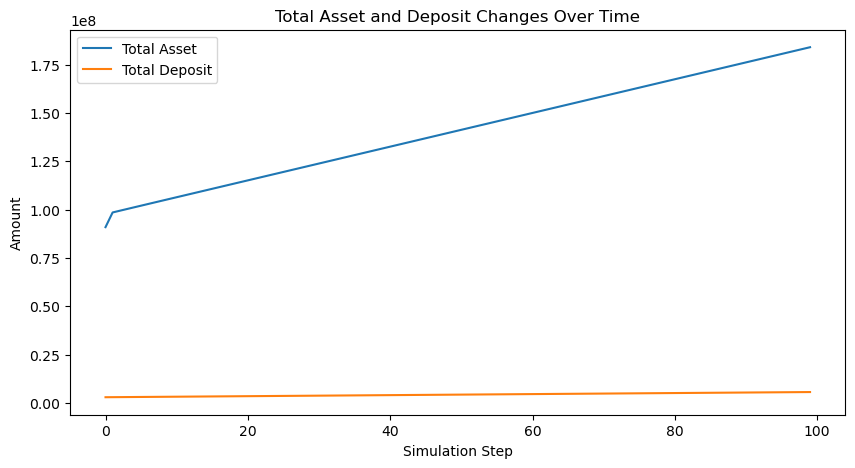

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(model_data["Total Asset"], label="Total Asset")
plt.plot(model_data["Total Deposit"], label="Total Deposit")
plt.xlabel("Simulation Step")
plt.ylabel("Amount")
plt.title("Total Asset and Deposit Changes Over Time")
plt.legend()
plt.show()


### Ratio of CBDC to Deposit in Commercial Bank Over Time

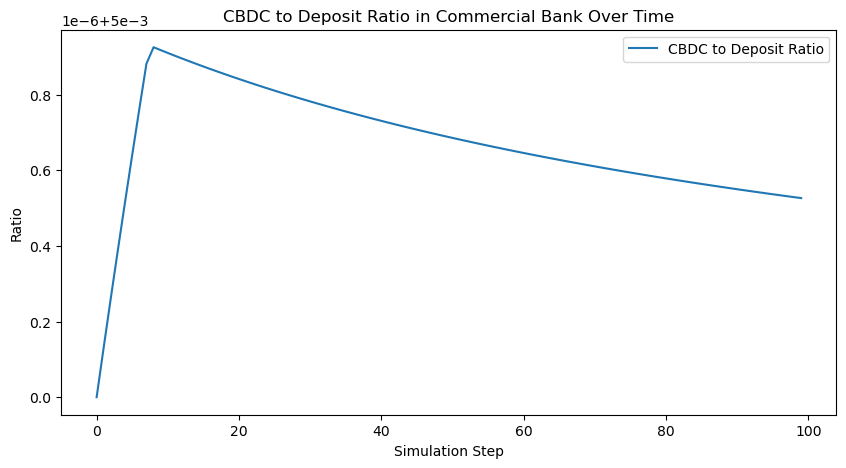

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(model_data["CBDC to Deposit Ratio"], label="CBDC to Deposit Ratio")
plt.xlabel("Simulation Step")
plt.ylabel("Ratio")
plt.title("CBDC to Deposit Ratio in Commercial Bank Over Time")
plt.legend()
plt.show()


### Bank Deposit Growth Rate Over Time

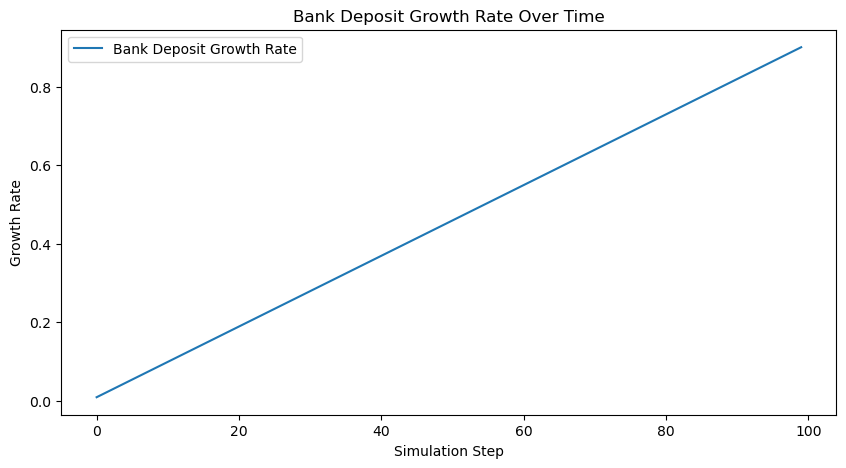

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(model_data["Bank Deposit Growth Rate"], label="Bank Deposit Growth Rate")
plt.xlabel("Simulation Step")
plt.ylabel("Growth Rate")
plt.title("Bank Deposit Growth Rate Over Time")
plt.legend()
plt.show()


### Distribution of CBDC Balances Across Consumers

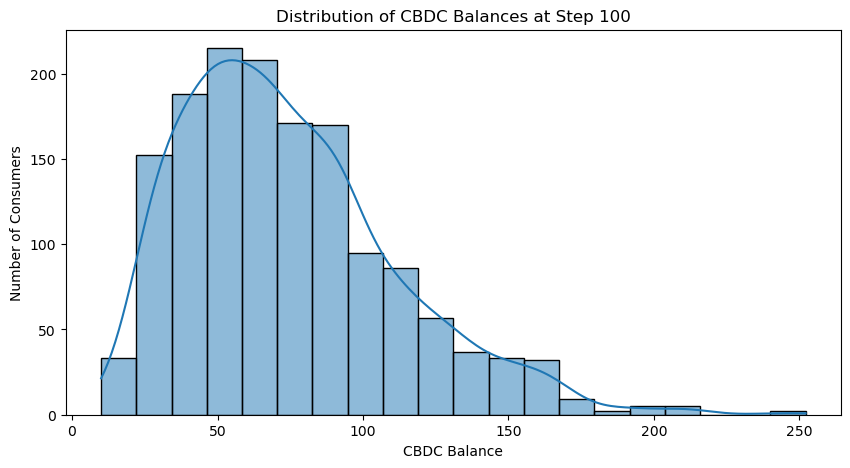

In [13]:
latest_step = agent_data["Step"].max()
latest_cbdc_balances = agent_data[agent_data["Step"] == latest_step]["CBDC"]

plt.figure(figsize=(10, 5))
sns.histplot(latest_cbdc_balances, bins=20, kde=True)
plt.xlabel("CBDC Balance")
plt.ylabel("Number of Consumers")
plt.title(f"Distribution of CBDC Balances at Step {latest_step}")
plt.show()